# Assignment 2: Voting Visualized

## Deadline

Oct. 24th

## Important notes

- Make sure you push on GitHub your notebook with all the cells already evaluated.
- Note that maps do not render in a standard Github environment. You should export them to HTML and link them in your notebook.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented.
- Please write all your comments in English, and use meaningful variable names in your code.
- Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything. 

## Background


* Are you curious to know what the political leanings of the people of Switzerland are?
* Do you wake up in a cold sweat, wondering which party won the last cantonal parliament election in Vaud?
* Are you looking to learn all sorts of visualizations, including maps, in Python?

If your answer to any of the above is yes, this assignment is just right for you. Otherwise, it's still an assignment, so we're terribly sorry.

The chief aim of this assignment is to familiarize you with visualizations in Python, particularly maps, and also to give you some insight into how visualizations are to be interpreted. The data we will use is the data on Swiss cantonal parliament elections from 2007 to 2018, which contains, for each cantonal election in this time period, the voting percentages for each party and canton.

For the visualization part, install [Folium](Folium) (_Hint: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!_). Folium's README comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find one TopoJSON file, containing the geo-coordinates of the cantonal borders of Switzerland.

One last, general reminder: back up any hypotheses and claims with data, since this is an important aspect of the course.

In [1]:
# Put your imports here.
import pandas as pd
import numpy as np
import os
import json
import folium
import matplotlib.pyplot as plt
from folium import plugins
from branca.colormap import linear
import urllib.request
import copy as cp


In [2]:
data_folder = './data/'

## Task 1: Cartography and census

__A)__ Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.

__B)__ Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?

__C)__ The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the average of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.  
  
Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?

<img src="plaw_crop.png" style="width: 600px;">
  
The figure is extracted from [this paper](https://arxiv.org/pdf/cond-mat/0412004.pdf) that contains more information about this family of distributions.

### Task1 __A)__ Display a Swiss map that has cantonal borders as well as the national borders.

In [3]:
#load topojson data
suisse_cantons = data_folder + 'ch-cantons.topojson.json'

m_suisse = folium.Map(
    location=[46.7,8],
    tiles='Mapbox Bright',
    zoom_start=7
)

# show the switerland map by TopoJson
folium.TopoJson(
    open(suisse_cantons),
    'objects.cantons',
    name='suisse_cantons'
).add_to(m_suisse)

folium.LayerControl().add_to(m_suisse)

#save the map
m_suisse.save('./Swiss_Map.html')

[Click to see the Swiss map](https://wanhaozhou.github.io/docs/Swiss_Map.html)

### Task1 __B)__ Plot a histogram of the population counts and explain your observations. 

In [4]:
#read the communes_pop excel table
commune_pop = pd.read_excel(data_folder+'communes_pop.xls',skiprows=5,skipfooter=7,
                            sheet_name='2017',names=['commune','population_Jan',
                                                     'birth_alive','death','natrual_increase',
                                                     'arrivals','departure','migratory_balance',
                                                     'divergence_statistic','population_Dec','variation_num',
                                                     'variation_ratio'])
commune_pop.head()

,commune,population_Jan,birth_alive,death,natrual_increase,arrivals,departure,migratory_balance,divergence_statistic,population_Dec,variation_num,variation_ratio
0,Suisse 2),8419550,87381,66971,20410,681011,635063,45948,-1778,8484130,64580,0.767024
1,- Zürich,1487969,17070,11076,5994,120593,108666,11927,-1544,1504346,16377,1.100628
2,>> Bezirk Affoltern,52904,517,310,207,4501,3862,639,21,53771,867,1.638817
3,......0001 Aeugst am Albis,1977,10,7,3,129,165,-36,-3,1941,-36,-1.820941
4,......0002 Affoltern am Albis,11900,128,93,35,1239,1029,210,1,12146,246,2.067227


In [5]:
#select the communes that the names start with '......' in the sheet. And then copy in the pop_per_commune
pop_per_commune = commune_pop[[name.startswith('......') for name in commune_pop.commune]].copy()
pop_per_commune.head()


,commune,population_Jan,birth_alive,death,natrual_increase,arrivals,departure,migratory_balance,divergence_statistic,population_Dec,variation_num,variation_ratio
3,......0001 Aeugst am Albis,1977,10,7,3,129,165,-36,-3,1941,-36,-1.820941
4,......0002 Affoltern am Albis,11900,128,93,35,1239,1029,210,1,12146,246,2.067227
5,......0003 Bonstetten,5435,47,25,22,374,322,52,3,5512,77,1.416743
6,......0004 Hausen am Albis,3571,27,20,7,298,217,81,5,3664,93,2.604313
7,......0005 Hedingen,3687,31,20,11,224,231,-7,3,3694,7,0.189856


In [6]:
#find out the commune that has the maxium population in January and present this commune other population information
pop_per_commune.loc[pop_per_commune['population_Jan'].idxmax()]

commune                 ......0261 Zürich
population_Jan                     402762
birth_alive                          5289
death                                3486
natrual_increase                     1803
arrivals                            35044
departure                           28684
migratory_balance                    6360
divergence_statistic                -1684
population_Dec                     409241
variation_num                        6479
variation_ratio                   1.60864
Name: 181, dtype: object

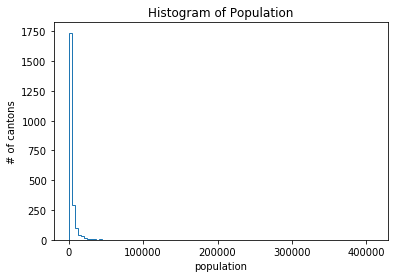

In [7]:
#plot out the histogram of population Counts in December
plt.hist(pop_per_commune.population_Dec,bins=100,histtype='step')
plt.title('Histogram of Population')
plt.ylabel('# of cantons')
plt.xlabel('population')
plt.show()

### Answers to Question Task1.B
### What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?
1). The urban and rural areas of switzerland are very different in population. The urban areas usually have much more population than the rural areas. But the number of rurals areas are much more than that of urban ones.

2). Although we cannot see any clear outlier in the figure above, the outliers do exist and were found in the following log-scale figures. 



### Task1 __C)__Recreate the Figure b) and d)

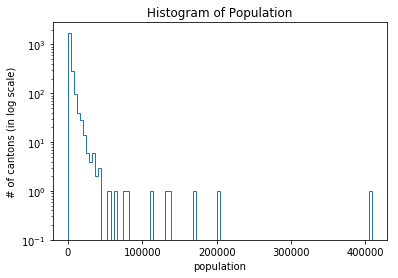

In [8]:
#recreate figure b) under the bin size as 100 without log-scale
array_100 = plt.hist(pop_per_commune.population_Dec,bins=100,log=True,histtype='step')
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population')
plt.show()

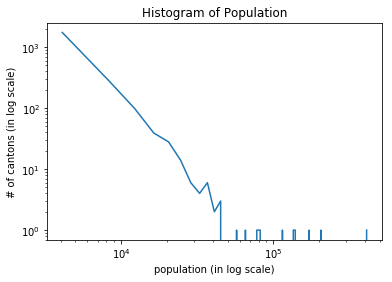

In [9]:
# recreate figure b) with log-scale, bin size=100
plt.loglog(array_100[1][1:],array_100[0])
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population (in log scale)')
plt.show()

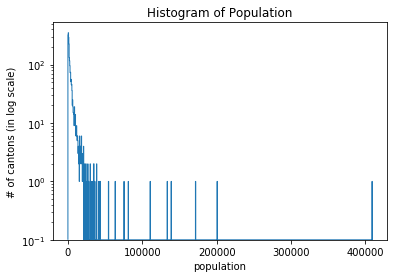

In [10]:
#recreate figure c) under the bin size as 1000 without log-scale
array_1000 = plt.hist(pop_per_commune.population_Dec,bins=1000,log=True,histtype='step')
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population')
plt.show()

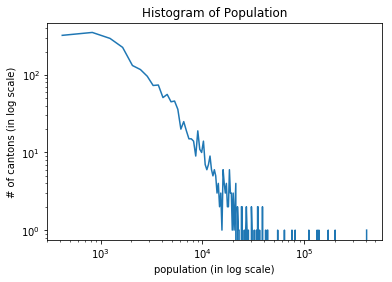

In [11]:
#recreate the figure c) in the log-scale, bin size=1000
plt.loglog(array_1000[1][1:],array_1000[0])
plt.title('Histogram of Population')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population (in log scale)')
plt.show()

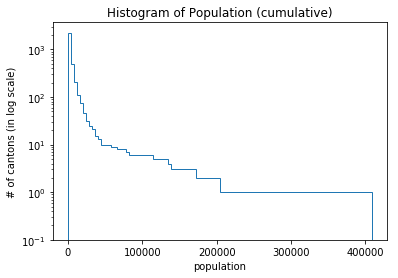

In [12]:
# plot the cumulative histogram under the bin size as 100 without log-scale
array_cumulative=plt.hist(pop_per_commune.population_Dec,bins=100,log=True,cumulative=-1,histtype='step')
plt.title('Histogram of Population (cumulative)')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population')
plt.show()

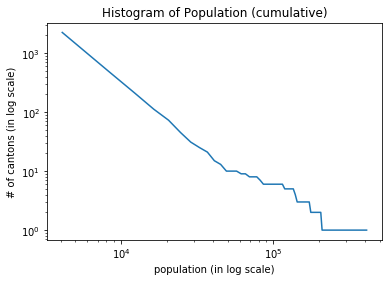

In [13]:
# recreate the figure d) in the log-scale, bin size=100
plt.loglog(array_cumulative[1][1:],array_cumulative[0])
plt.title('Histogram of Population (cumulative)')
plt.ylabel('# of cantons (in log scale)')
plt.xlabel('population (in log scale)')
plt.show()

### Answers to Task1.C
###  Provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?

As the figure shown in Task1.B, more or less we can observe that the larger is the population and the fewer of the number of the communes. However, the outliers which represent the larger population are hardly observed in this graph due to the huge difference between the number of cantons with small population and those with large population.

Whereas in the Task1.C, the outlier problem is perfectly solved by the log-log scale. In the log-log scale, the relationship between the frequency of each population and corressponding population was more clearly observed, which means **the larger the population and the smaller number of commune**. Moreover, the **outliers which mainly are urban communes (Zurich, Genève, Basel, Laussanea, Bern, etc.) are clearly shown in this case since the gap between the log(counts of big population communes) and log(counts of small population communes) decreased**.

But one thing should be noted is that in the log-log plot, the noise could be introduced on the tail of the axis due to the small bin size. To avoid introducing noise, the cumulative histogram was used. In the case of cumulative histogram, not only the relationship of the two variables was clearly shown but also the noise can be eliminated.

## Task 2: Parties visualized

We provide a spreadsheet, `data/voters.xls`, (again) collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/force-partis.assetdetail.217195.html), which contains the percentage of voters for each party and for each canton. For the following task, we will focus on the period 2014-2018 (the first page of the spreadsheet). Please report any assumptions you make regarding outliers, missing values, etc. Notice that data is missing for two cantons, namely Appenzell Ausserrhoden and Graubünden, and your visualisations should include data for every other canton.


__A)__ For the period 2014-2018 and for each canton, visualize, on the map, **the percentage of voters** in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?

__B)__ For the same period, now visualize **the number of residents** in each canton who voted for UDC.

__C)__ Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?

For part B, you can use the `data/national_council_elections.xslx` file ([guess where we got it from](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/participation.assetdetail.81625.html)) to have the voting-eligible population of each canton in 2015.

### Task2 __A)__ visualize **the percentage of voters** in that canton who voted for the party UDC



In [14]:
#read the excel and skip those rows with value missing in UDC
voters_udc = pd.read_excel(data_folder+'voters.xls',sheet_name=0,usecols=[0,10],names=['canton','udc'])
cantons = pd.read_csv(data_folder+'cantons.csv')
nce_raw = pd.read_excel(data_folder+'national_council_elections.xlsx',
                    sheet_name=0,names=['canton','reg_voter','elector','participation'])

### Supplement remarks for the following cleaning data phase：
We observed that the expression of the cantons names were not inconsistent in different files. For instances, the cantons names in Json files are in English but are in French in the voters files, which is not convenient for the further data analysis.

However the order of the cantons names are the same no matter which file they are in,which means the same canton always has the same index among different files.
 
So after deleting the rows that are not cantons, we decided to combine the 'cantons' and the 'voters_udc_nona' by the index to keep the cantons names consistent.

In [15]:
### cleaning the "national_council_elections" data ###
#drop out the NaN values
nce_nona = nce_raw.dropna()
#drop out the 'Total' row
nce = nce_nona.drop(6)
#reset the index 
nce.index = range(len(nce.index))
nce.head()

,canton,reg_voter,elector,participation
0,Zurich,907623,428837,47.2484
1,Berne,729203,357770,49.0632
2,Lucerne,271143,138096,50.9311
3,Uri 1),26414,15091,57.1326
4,Schwytz,102145,54857,53.705


In [16]:
### cleaning the "voters" data ###
#Since the cantons named Appenzell Ausserrhoden and Graubünden had no data, they locate in the table at row 23 and row 25 respectively
#we set these two rows' vaules as a extremely small values so that they will not impact the further calculation
voters_udc['udc'][23] = 1e-6
voters_udc['udc'][25] = 1e-6

#drop out the NaN values
voters_udc_nona = voters_udc.dropna()
#reset the data
voters_udc_nona.index = range(len(voters_udc_nona.index))
voters_udc_nona.head()

,canton,udc
0,Zurich,30.0232
1,Berne,26.7609
2,Lucerne,24.1156
3,Uri 1),24.0532
4,Schwytz,33.1151


In [17]:
###the "cantons " data ###
cantons.head()

,Code,Canton of,Since,Capital,Population,GDP percapita (2014)[16]in CHF,Area (km2),Density (per km2)[Note 4],No. munic.,Official languages
0,ZH,Zürich,1351,Zürich,"1,504,346[17]","96,411","1,729",701,168,German
1,BE,Bern,1353,Bern,"1,031,126[18]","76,307","5,960",158,352,"German, French"
2,LU,Luzern,1332,Lucerne,"403,397[19]","65,119","1,494",233,83,German
3,UR,Uri,1291,Altdorf,"36,145[20]","51,332","1,077",33,20,German
4,SZ,Schwyz,1291,Schwyz,"155,863[21]","58,788",908,143,30,German


In [18]:
## For Question A visualize the percentage on the Map, 
#we combined the voter table (which contained the data of percentage of voters)
#and cantons table (whcih had the cantons names and Code in English)in advance

voters_cantons = pd.merge(voters_udc_nona,cantons,left_index=True,right_index=True)
voters_cantons.head()

,canton,udc,Code,Canton of,Since,Capital,Population,GDP percapita (2014)[16]in CHF,Area (km2),Density (per km2)[Note 4],No. munic.,Official languages
0,Zurich,30.0232,ZH,Zürich,1351,Zürich,"1,504,346[17]","96,411","1,729",701,168,German
1,Berne,26.7609,BE,Bern,1353,Bern,"1,031,126[18]","76,307","5,960",158,352,"German, French"
2,Lucerne,24.1156,LU,Luzern,1332,Lucerne,"403,397[19]","65,119","1,494",233,83,German
3,Uri 1),24.0532,UR,Uri,1291,Altdorf,"36,145[20]","51,332","1,077",33,20,German
4,Schwytz,33.1151,SZ,Schwyz,1291,Schwyz,"155,863[21]","58,788",908,143,30,German


In [19]:
##### For Question B visualize the number of voters for UDC, 
#we combined voters table (had percentage of voters) and the national_council_elections table (had the total number of the voters) in  advance

voters_udc_nce = pd.merge(nce,voters_udc_nona,left_index=True,right_index=True)
voters_udc_nce.head()

,canton_x,reg_voter,elector,participation,canton_y,udc
0,Zurich,907623,428837,47.2484,Zurich,30.0232
1,Berne,729203,357770,49.0632,Berne,26.7609
2,Lucerne,271143,138096,50.9311,Lucerne,24.1156
3,Uri 1),26414,15091,57.1326,Uri 1),24.0532
4,Schwytz,102145,54857,53.705,Schwytz,33.1151


In [20]:
# load the json file
geo_data = json.load(open(suisse_cantons))

In [21]:
# visualize the percentage of voters on the Swiss map
swiss_map_percent=folium.Map([46.7,8], zoom_start=7)

swiss_map_percent.choropleth(geo_data=geo_data, data=voters_cantons,
                             columns=['Code', 'udc'],
                             key_on='feature.id',
                             topojson = 'objects.cantons',
                             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                             legend_name='Percentage of Voters for UDC (%)')
swiss_map_percent.save('Swiss_Map_Percent.html')

[Click to see the percentage of voters for UDC](https://wanhaozhou.github.io/docs/Swiss_Map_Percent.html)

###  Answer to the Task2.A
### Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?
1). As shown in the map above, the German-speaking parts are in dark violet revealing that UDC is more popular in the German-speaking part.

### Task2 __B)__  Visualize the number of residents in each canton who voted for UDC.

In [22]:
# calculate the number of the voters by using the following equation: electors number * percentage of voters for UDC
voters_udc_nce['udc_num'] = voters_udc_nce['elector']*voters_udc_nce['udc']*0.01

In [23]:
# merge the new 'voters_udc_nce' whcih has the data of the number of the voters now with the cantons again 
voters_udc_nce = pd.merge(voters_udc_nce,cantons,left_index=True,right_index=True)

In [24]:
#visualize the number of the UDC voters on the Swiss map
swiss_map_number = folium.Map([46.7,8], zoom_start=7)

swiss_map_number.choropleth(geo_data=geo_data, data=voters_udc_nce,
                            columns=['Code', 'udc_num'],
                            key_on='feature.id',topojson='objects.cantons',
                            fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                            legend_name='Numbers of UDC voters ')
swiss_map_number.save('Swiss_Map_Number.html')

[Click to see the voters for UDC](https://wanhaozhou.github.io/docs/Swiss_Map_Number.html)

### Answers to Task2.C
### Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?
1). The second one is more informative in case of a national election since this kind of election judges on the absolute number of voters but not the percentage. In the second map, we can clearly see which canton has a larger number of voters for UDC. But in the first map, we only know the percentage of the voters in each canton. Maybe in those cantons with high percentage but with small population, they can induce wrong decision and misunderstanding.

2). In case of cantonal parliament elections, the party needs to have the largset number of voters in the canton to win which means it needs to have the largest percentage of voters in the cantons. Therefore the first map which shows the percentage of voters for UDC in each canton is more directive and informative for the cantonal parliament elections.

## Task 3: More socialism or more nationalism?

In this section, we focus on two parties that are representative of the left and the right on the Swiss political spectrum. You will propose a way to visualize their influence over time and for each canton.

__A)__ Take the two parties [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre) and [`PS`](https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland) (Parti socialiste suisse). For each canton, we define 'right lean' in a certain period as follows:

$$\frac{VoteShare_{UDC} - VoteShare_{PS}}{VoteShare_{UDC} + VoteShare_{PS}}$$  

Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the [röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben) ?

__B)__ For each party, devise a way to visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. Propose a way to visualize this evolution of the party over time, and justify your choices. There's no single correct answer, but you must reasonably explain your choices.

### Task3 __A)__  Visualize the right lean of each canton on the map. 

In [25]:
# extract the data for PS party using the similar way we did for the UDC in the above part
voters_ps = pd.read_excel(data_folder+'voters.xls',sheet_name=0,usecols=[0,8],names=['canton','ps'])
voters_ps['ps'][23] = 1e-6
voters_ps['ps'][25] = 1e-6
voters_ps_nona = voters_ps.dropna()
voters_ps_nona.index = range(len(voters_ps_nona.index))

In [26]:
#combine the udc party data we obained in the Task 2 and the PS party data.
voters_udc_ps = pd.merge(voters_udc_nona, voters_ps_nona, left_on='canton',right_on='canton')

#compute the right lean value by following the equation shown in the question A.
voters_udc_ps['right_lean'] = (voters_udc_ps['udc']-voters_udc_ps['ps'])/(voters_udc_ps['udc']+voters_udc_ps['ps'])

#since we don't need the percentage of the voters for the parties, we drop out these two percentage columns
voters_udc_ps_right_lean = voters_udc_ps.drop(columns=['udc', 'ps'])

#merge the table with right lean data with the cantons table which has the cantons names
voters_cantons_right_lean = pd.merge(voters_udc_ps_right_lean,cantons,left_index=True,right_index=True)
voters_cantons_right_lean.head()

,canton,right_lean,Code,Canton of,Since,Capital,Population,GDP percapita (2014)[16]in CHF,Area (km2),Density (per km2)[Note 4],No. munic.,Official languages
0,Zurich,0.207214,ZH,Zürich,1351,Zürich,"1,504,346[17]","96,411","1,729",701,168,German
1,Berne,0.0902857,BE,Bern,1353,Bern,"1,031,126[18]","76,307","5,960",158,352,"German, French"
2,Lucerne,0.341078,LU,Luzern,1332,Lucerne,"403,397[19]","65,119","1,494",233,83,German
3,Uri 1),0.298833,UR,Uri,1291,Altdorf,"36,145[20]","51,332","1,077",33,20,German
4,Schwytz,0.438521,SZ,Schwyz,1291,Schwyz,"155,863[21]","58,788",908,143,30,German


In [27]:
# in order to see the "röstigraben", we customize the geojson to
# illustrate the German-speaking part and French-peaking part

# for convenience we use the converted geojson file when plotting the boundary of German-speaking parts
# and French-speaking parts

# use "geojson" data for maps
with urllib.request.urlopen('https://raw.githubusercontent.com/wanhaozhou/ADA-utils/master/cantons.json') as url:
    geo_json_data_raw = json.loads(url.read().decode())


cantons_new = pd.read_csv(data_folder+'cantons.csv')
cantons_new = cantons_new.set_index(['Code'])
t1 = cp.deepcopy(geo_json_data_raw)
t2 = cp.deepcopy(geo_json_data_raw)

# we use the cantons.csv file to divide geojson file into different parts
def divide_by_language(geo_data,language):
    if(language=='French'):
        for i in range(25):
            l=cantons_new.loc[geo_data['features'][i]['id']]['Official languages']
            if(l=='German' or l=='German, French' or l=='French, German' or l=='German, Romansh, Italian'):
                geo_data['features'][i]={}
    
    if(language=='German'):
         for i in range(25):
            l=cantons_new.loc[geo_data['features'][i]['id']]['Official languages']
            if(l=='French' or l=='German, French' or l=='French, German'):
                geo_data['features'][i]={}
                    
    return geo_data

# these two geojson files are used to illustrate the German-speaking part and the French-speaking part
geo_json_data_german = divide_by_language(t1, 'German')
geo_json_data_french = divide_by_language(t2, 'French')

In [28]:
m_udc_ps = folium.Map([46.7,8],zoom_start=7)

def style_function_german(feature):
    return {
        'fillOpacity': 0,
        'weight': 4,
        'color':'green'
    }

def style_function_french(feature):
    return {
        'fillOpacity': 0,
        'weight': 4,
        'color':'blue'
    }

# build the map for German-speaking part
folium.GeoJson(
    geo_json_data_german,
    name='German Speaking',
    style_function = style_function_german
).add_to(m_udc_ps)

# build the map for French-speaking part
folium.GeoJson(
    geo_json_data_french,
    name='French Speaking',
    style_function = style_function_french
).add_to(m_udc_ps)

# build the right-lean map, here we stick to the topojson data
m_udc_ps.choropleth(geo_data=geo_data, 
                data=voters_cantons_right_lean,
                columns=['Code', 'right_lean'],
                key_on='feature.id',
                topojson='objects.cantons',
                fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0,
                legend_name='Right Lean', name = 'Right Lean Tendency')

folium.LayerControl().add_to(m_udc_ps)

m_udc_ps.save('M_UDC_PS.html')


[Click to see the right lean tendency](https://wanhaozhou.github.io/docs/M_UDC_PS.html)

### Answers to Task3. A
### What conclusions can you draw this time? Can you observe the röstigraben ?
1). As shown in the right lean map, gernerally most of the German-speaking areas are in dark violet or light violet whereas most of the French-speaking areas and Italian areas are in light blue which means the German-speaking areas voters are more or less more nationalism whereas the French-speaking and Italian-speaking areas voters are more socialism.  

2). Yes, we can observe the röstigraben by showing the contours of the French-speaking parts and German-speaking parts in different colors. We can see that the röstigraben is more or less overlaped with the spliting line of yellow and orange, meaning less right lean and more right lean respectively.

### Task3 __B)__  For each party, devise a way to visualize the difference between its 2014-2018 vote share and its 2010-2013 vote share for each canton

In [29]:
#To visualize the difference of the vote share between the two period, we calculated the difference percentage by this equation :
#(2014_2018-2010_2013)/2014_2018
#and shown this difference in color on the map

#read the sheet 2014-2018, and only extracted the columns of cantons names, UDC as well as PS
data_14_18 = pd.read_excel(data_folder + '/voters.xls',sheet_name= 'actuel (2014-2018)', 
                           usecols=[0,8,10],header =3,skipfooter=55)

#drop out the redundant rows and repalce the nan by 0.1 for the purpose of further calculation convenience 
data_14_18 = data_14_18.reset_index().drop([0,1,7,13,19,25]).reset_index().drop(columns=['level_0']).replace(np.nan,0.01)

#combine the data of 2014-2018 with the cantons codes
data_14_18 = pd.concat([cantons.Code,data_14_18],axis=1)

#Cleaned the sheet 2010-2013 using the similar way we did for sheet 2014-2018 in the above part
data_10_13 = pd.read_excel(data_folder + '/voters.xls',sheet_name= '2010-2013', 
                           usecols=[0,8,10],header =3,skipfooter=50)
data_10_13 = data_10_13.reset_index().drop([0,1,7,13,19,25]).reset_index().drop(columns=['level_0']).replace(np.nan,0.01)
data_10_13 = pd.concat([cantons.Code,data_10_13],axis=1)

#computed the difference between 2014-2018 and 2010-2013 for PS and UDC respectively
dif_PS = pd.DataFrame({'Code':data_14_18.Code,
                    'Difference':(data_14_18['PS']-data_10_13['PS'] )/data_10_13['PS']})
dif_UDC = pd.DataFrame({'Code':data_14_18.Code,
                    'Difference':(data_14_18['UDC']-data_10_13['UDC'] )/data_10_13['UDC']})


In [30]:
#Visualize the difference between 2014-2018 and 2010-2013 for PS on Swiss map
m_PS = folium.Map([46.7,8],zoom_start=7)
m_PS.choropleth(geo_data=geo_data,
                data=dif_PS,
                columns=['Code', 'Difference'],
                key_on='feature.id',
                topojson='objects.cantons',
                fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                legend_name='Difference for PS')
m_PS.save('M_PS.html')

[Click to see the difference for party 'ps'](https://wanhaozhou.github.io/docs/M_PS.html)

### Observation of the votes share difference between 2014-2018 and 2010-2013 for PS.

As we see from the map, most of the areas are in light blue or in blue which means that from 2010-2013 to 2014-2018, the votes share for the PS party has decreased or only a little bit increased in most of the cantons. However, there is one conspicuous canton named Nidwald in violet revealing that this canton tended to support the PS party from 2010-2013 to 2014-2018.

In [31]:
#Visualize the difference between 2014-2018 and 2010-2013 for UDC on Swiss map
m_UDC = folium.Map([46.7,8],zoom_start=7)
m_UDC.choropleth(geo_data=geo_data, 
                data=dif_UDC,
                columns=['Code', 'Difference'],
                key_on='feature.id',
                topojson='objects.cantons',
                fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                legend_name='Vote Share Difference for UDC', name = 'vote share difference for UDC')
m_UDC.save('M_UDC.html')

[Click to see the difference for party 'udc'](https://wanhaozhou.github.io/docs/M_UDC.html)

### Observation of the voters share difference between 2014-2018 and 2010-2013 for UDC
From the map for the UDC party vote share, generally most of the cantons are in blue which means the votes share for the UDC party has decreased as well from 2010-2013 to 2014-2018. Noted that only two cantons named Jura and St. Gall are in violet meaning that these two cantons' votes share has increased from 2010-2013 to 2014-2018.

### Task3 __B)__  Propose a way to visualize this evolution of the party over time, and justify your choices.

**In this part, we attemt to use all data available to illustrate the trend over time**

In [32]:
# we are gonna to make a choropleth with different layers to show the evolution of the PS and of the UDC over time

cantons = cantons.drop(columns=['Canton of','Since','Capital','Population',
                                'GDP percapita (2014)[16]in CHF','Area (km2)',
                                'Density (per km2)[Note 4]','No. munic.','Official languages'])


# define all the sheets we are going to use
sheet_list = ['actuel (2014-2018)', '2013-2017', '2012-2016', '2011-2015', '2010-2014', 
             '2010-2013','2009-2012', '2008-2011','2007-2010']

sheet_list.reverse()

# return a list of data frames containing all data
def get_ps_udc_data (sheet_list):
    pds = []
    for i, sheet in enumerate(sheet_list):
        df = pd.read_excel(data_folder+'voters.xls',sheet_name= sheet_list[i],
                           usecols=[0,2,8,10],names=['Cantons','Years','PS','UDC'])
        
        df['PS'][23] = 1e-6; df['PS'][25] = 1e-6; df['UDC'][23] = 1e-6; df['UDC'][25] = 1e-6
        
        if sheet == '2007-2010':
            df['PS'][21] = 1e-6; df['UDC'][21] = 1e-6
        df_nona = df.dropna()
        df_nona.index = range(len(df_nona.index))
        df_cantons = pd.merge(df_nona,cantons,left_index=True,right_index=True)
        pds.append(df_cantons)
    return pds

udc_ps = get_ps_udc_data(sheet_list)


In [33]:
# define two maps for two parties
m_udc_evolution = folium.Map([47.5,8],zoom_start=6.5)
m_ps_evolution = folium.Map([47.5,8],zoom_start=6.5)

# create the evolution map iteratively
def create_evolution_map(init_map, dfs, party_name, colors):
    for i in range(len(dfs)):
        init_map.choropleth(geo_data = geo_data, data = dfs[i],
                            columns = ['Code', party_name], key_on='feature.id',
                            topojson = 'objects.cantons', 
                            fill_color = colors, fill_opacity=0.7, line_opacity=0.2,
                            legend_name = party_name + '\t' + sheet_list[i],
                            name = party_name + '\t' + sheet_list[i])
    folium.LayerControl().add_to(init_map)

create_evolution_map(m_udc_evolution, udc_ps, 'UDC', 'BuPu')
create_evolution_map(m_ps_evolution, udc_ps, 'PS', 'YlOrRd')
m_udc_evolution.save('m_udc_evolution.html')
m_ps_evolution.save('m_ps_evolution.html')


[Click to see the evolution graph for party 'udc'](https://wanhaozhou.github.io/docs/m_udc_evolution.html)

[Click to see the evolution graph for party 'ps'](https://wanhaozhou.github.io/docs/m_ps_evolution.html)

### Remarks for Method 1: using multiple layers to stack together
Using this method, two maps are created for UDC and PS respectively. Both maps contain 9 periods layers stacking on the same map. We can select the period we want to observe by clicking the corresponding map box on the right side.

In this case we can more or less grasp a basic idea of the vote share distribution among various cantons over years. Generally, the majority of the French-speaking cantons always have higher votes share for PS and the votes share decreased gradually from the western Germam-speaking parts to the eastern German-speaking parts. However, the maps of the votes share for UDC comes to the other way around. The majority of the German-speaking cantons always had higher votes share for UDC whereas the French-speaking parts always had fewer votes share over these years.

However, we addmitted that the evolution over the years wasn't presented very well in this map, and to show the trend vs. time, we adopt an alternative method presented below.

In [34]:
# alternatively, we use the TimeSliderChoropleth function to show the evolution with time.

######  Creating the style dictionary ########

# first conver the year to the standard type
n_periods = 9
datetime_index = pd.date_range('2010-1-1', periods=n_periods, freq='Y')
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')

# construct the style dict the TimeSliderChoropleth needs
def make_style_dict(voter_list,features,colormap):
    style_dict={}
    for i in range(len(voter_list[0])):
        style_dict[voter_list[0]['Code'][i]]={}
    for c, value in enumerate(voter_list):
        df={}
        df['id']=value['Code']
        df[features]=value[features]
        df=pd.DataFrame(df)
        df=df.set_index(['id'])
        df[features]=df[features].apply(colormap)
        for i in range(len(df)):
            style_dict[df.index[i]][dt_index[c]]={'color':df[features][i],'opacity':1.0}
    return style_dict

In [35]:
# use "geojson" data for maps
with urllib.request.urlopen('https://raw.githubusercontent.com/wanhaozhou/ADA-utils/master/cantons.json') as url:
    geo_json_data = json.loads(url.read().decode())

In [36]:
# construct the time slider for udc
colormap_UDC = linear.BuPu_09.scale(0,38)
udc = make_style_dict(udc_ps,'UDC',colormap_UDC)
m_udc_evolution_time = folium.Map([46.7,8], zoom_start=7)
plugins.TimeSliderChoropleth(geo_json_data, udc).add_to(m_udc_evolution_time)
m_udc_evolution_time.save('m_udc_evolution_time.html')

[Click to see the evolution graph with time for party 'udc'](https://wanhaozhou.github.io/docs/m_udc_evolution_time.html)

In [37]:
# construct the time slider for ps
colormap_PS = linear.YlOrRd_05.scale(0,33)
ps = make_style_dict(udc_ps,'PS',colormap_PS)
m_ps_evolution_time = folium.Map([46.7,8], zoom_start=7)
plugins.TimeSliderChoropleth(geo_json_data, ps).add_to(m_ps_evolution_time)
m_ps_evolution_time.save('m_ps_evolution_time.html')

[Click to see the evolution graph with time for party 'ps'](https://wanhaozhou.github.io/docs/m_ps_evolution_time.html)

### Remarks for Method 2: using the TimeSliderChoropleth function
This time we can clearly see the evolution of the votes share for different cantons over years by tuning the timesline. 

For the PS party, we observed the similar situation with the one we saw in Method 1. There was only a little variation for the canotons over years and mainly the French-speaking parts are more likely to vote for the PS. 
But for the UDC party map, we can see that the main supporters for UDC are from the German-speaking parts; in addition, we found that the vote share of French-speaking parts was gradually increasing over the years. That's what we neglect in Method 1.

Obviously, the Method 2 can better show the evolution over time.


### Comparison between two methods:
#### Method 1:The legends are various in different time period. 
Advantage: The comparison among different cantons in the same period is more obvious.

Drawback: The comparisons among different time periods is obscure. 

#### Method 2: The legend is always the same in all the time periods.
Advantage: The comparison among different years is more concrete.

Drawback: In the same period, the comparison among different cantons is less evident compared to the method 1.